# Example: Extrinsic calibration of 15 GoPro cameras

Suppose we have 15 GoPro cameras capturing a target.  This example demonstrates how to calibrate these cameras into a unified world coordinate system.  The steps include:

1. Choose the camera parameters to be optimized (Step 0),
2. Initialize the extrinsic parameters by a linear method (Step 3), and
3. Fine-tune the extrinsic parameters non-linearly by a bundle adjustment (Step 4).

It also includes an additional step to rotate and scale the world coordinate system such that a chess or AR markers on the floor be on $z=0$ plane (Step 6).

## Input

1. Intrinsic parameter:  `data/ba/gopro10-wide5.3k.json`
   * This is a JSON file including a 3x3 matrix `K` and an array `d` of length 7 representing $k_1, k_2, p_1, p_2, k_3, k_4, k_5$, and $k_6$.
   * You can calibrate your own camera using examples in this repo.
   * We assume all the cameras share a same intrinsic parameter (you can fine-tune the parameters as you see below).
2. 2D-2D correspondences:  `data/ba/kp.txt.bz2`
   * This follows the file format of [Bundle Adjustment in the Large](https://grail.cs.washington.edu/projects/bal/), but we use the 2D observation part only.  This is because the format can include only a limited part of `K` and `d`.
   * As a result, the camera parameter and the 3D posision can be filled by $0$ or any random numbers.
3. (optional)
   * A chessboard or AR marker points on the floor:  `data/ba/floor.txt.bz2`
     * Again, this is a file of the BAL format, and we use only the 2D observation part.
   * The scaling factor:  `SCALE` parameter below.
     * If you use the four corners of an AR marker, this describes the edge length of the marker.  For example, if the length was 15cm, you may set `SCALE=150` if you prefer millimeters. This factor is up to you.


## Configurable parameters (see Step 0)

* We can specify the parameters to be optimized.  For example, we can fix the intrinsic parameters while optimizing the extirinsic parameters, or we can optimize both simultaneously.
* We can specify any scaling factor.  It simply scales the AR marker positions to the given scale.

## FAQ

1. I have my own initial guess of the intrinsic and/or extrinsic parameters.
   * Replace the steps 1 to 3 as you need.  As long as the parameters are prepared in the same format, the bundle adustment from the step 4 will work for you.
2. I want to fix the intrinsic parameter of camera A and B, while optimizing that of camera C.
   * This is not implemented.  Your PR is welcome.

## Step 0: Prerequisites and configurable parameters

In [1]:
%matplotlib notebook

import numpy as np
import sys
import json
import bz2
import cv2
import matplotlib.pyplot as plt
import pycalib  # pip install pycalib-simple

# [INPUT] intrinsic parameters
FILE_INCALIB = '../data/ba/gopro10-wide5.3k.json'

# [INPUT] corresponding points
FILE_BAL = '../data/ba/kp.txt.bz2'

# [INPUT] 2D corners of an AR marker on the floor
FILE_FLOOR = '../data/ba/floor.txt.bz2'

# [INPUT] scaling factor
SCALE = 150

# [OUTPUT] intermediate result after the bundle adjustment
FILE_RESULT_TMP = 'output_tmp.json'

# [OUTPUT] final result after the z-plane transform
FILE_RESULT = 'output.json'

# [INPUT] parameters to be optimized
MASK = pycalib.ba.make_mask(
    r=True,
    t=True,
#    f=True,
#    u0=True,
#    v0=True,
#    k1=True,
#    k2=True,
#    p1=True,
#    p2=True,
#    k3=True,
#    k4=True,
#    k5=True,
#    k6=True,
    )


## Step 1: Load the intrinsic parameters

In [2]:
cameraMatrix, distCoeffs, _, _, _ = pycalib.util.load_calib(FILE_INCALIB)
cameraMatrix = cameraMatrix[0]
distCoeffs = distCoeffs[0]

print(f'K = {cameraMatrix}')
print(f'd = {distCoeffs}')

K = [[2.43982948e+03 0.00000000e+00 2.65496726e+03]
 [0.00000000e+00 2.43982948e+03 1.48246290e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
d = [ 5.74910987e+00  1.58268611e+00  1.23611052e-05 -3.93892226e-04
 -5.15783512e-02  6.06280088e+00  3.10045734e+00  6.33818101e-02]


## Step 2: Load 2D-2D correspondences

In [3]:
with bz2.open(FILE_BAL) as fp:
    camera_params, points_3d, camera_indices, point_indices, points_2d = pycalib.bal.bal_read(fp)
Nc = len(camera_params)
print(f'{Nc} cameras, {len(points_3d)} 3D points, {len(points_2d)} observations')

15 cameras, 1404 3D points, 6560 observations


## Step 3:  Initial linear camera calibration

<IPython.core.display.Javascript object>


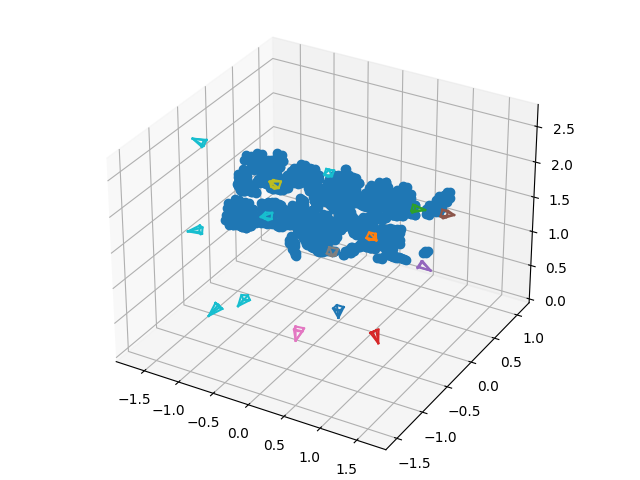

In [4]:
camera_params = pycalib.ba.encode_camera_params(
    np.tile(np.eye(3), (Nc, 1, 1)),
    np.tile(np.zeros((3,1)), (Nc, 1, 1)),
    np.tile(cameraMatrix, (Nc, 1, 1)),
    np.tile(distCoeffs, (Nc, 1)))
camera_params, points_3d = pycalib.bal.bal_recalib(camera_params, camera_indices, point_indices, points_2d)

pycalib.plot.plotCameras(camera_params, points_3d)
plt.show()

## Step 4: Bundle adjustment

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.3368e+07                                    1.69e+08    
       1              2         3.3290e+06      6.00e+07       4.21e+00       2.24e+07    
       2              3         1.2058e+04      3.32e+06       5.31e-01       1.53e+06    
       3              4         2.7468e+03      9.31e+03       2.81e-02       1.20e+04    
       4              5         2.7464e+03      4.41e-01       1.84e-04       8.79e+00    
       5              6         2.7464e+03      1.25e-05       3.57e-06       4.93e+00    
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 6.3368e+07, final cost 2.7464e+03, first-order optimality 4.93e+00.
reprojection error (RMSE) = 0.8823100420884792


<IPython.core.display.Javascript object>


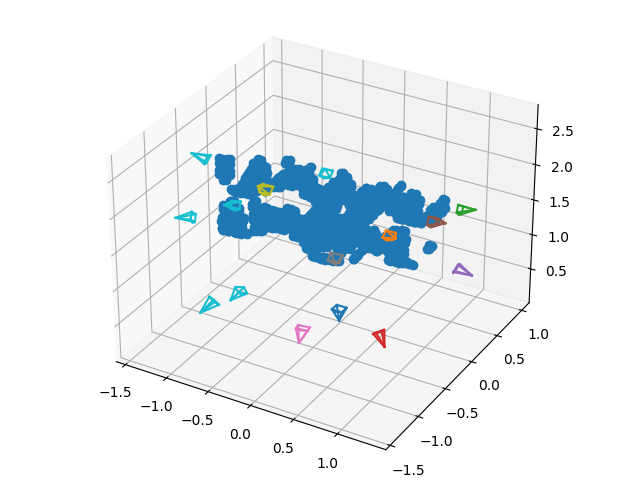

In [5]:
camera_params, points_3d, reproj, ret = pycalib.ba.bundle_adjustment(camera_params, points_3d, camera_indices, point_indices, points_2d, mask=MASK)

#print(ret)
print(f'reprojection error (RMSE) = {reproj}')
pycalib.plot.plotCameras(camera_params, points_3d)
plt.show()

## Step 5: Save

In [6]:
R, T, K, D = pycalib.ba.decode_camera_params(camera_params)
pycalib.util.save_calib(FILE_RESULT_TMP, camera_matrix=K, dist_coeffs=D, rmat=R, tvec=T, reproj=reproj)

## Step 6: $z$-plane

Suppose we capture an AR marker as shown below, and by running `cv2.aruco.detectMarkers()`, we assume some cameras could detect the marker successfully, and the detected points are stored in BAL format as `data/ba/floor.txt.bz2`.

![z-plane.jpg](../data/ba/floor.jpg)


15 cameras, 4 3D points, 36 observations

The four corners in WCS are
[[ 0.24500796 -0.26702261 -0.29258851  0.21963212]
 [ 0.53994057  0.55988725  0.13550858  0.11853038]
 [ 2.22432502  2.20935015  2.49377816  2.51223524]]



<IPython.core.display.Javascript object>


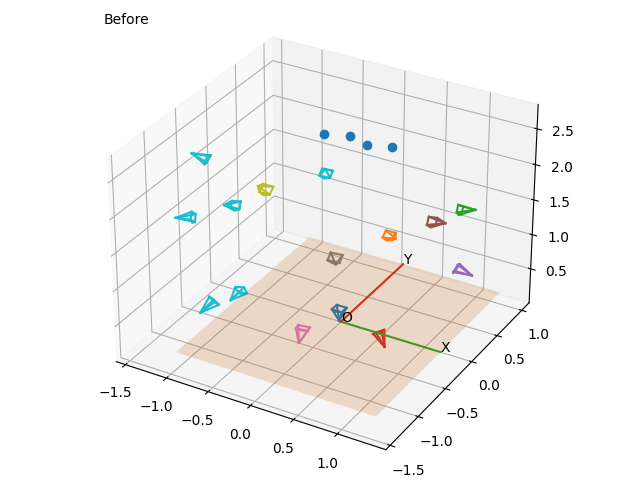


The four corners in WCS are
[[-7.62004019e+01  7.60269406e+01  7.64137081e+01 -7.62712814e+01]
 [ 7.60381702e+01  7.59411297e+01 -7.61289662e+01 -7.59073678e+01]
 [ 5.73792687e-01 -5.01144895e-03  5.34698879e-01 -3.06395621e-01]]



<IPython.core.display.Javascript object>


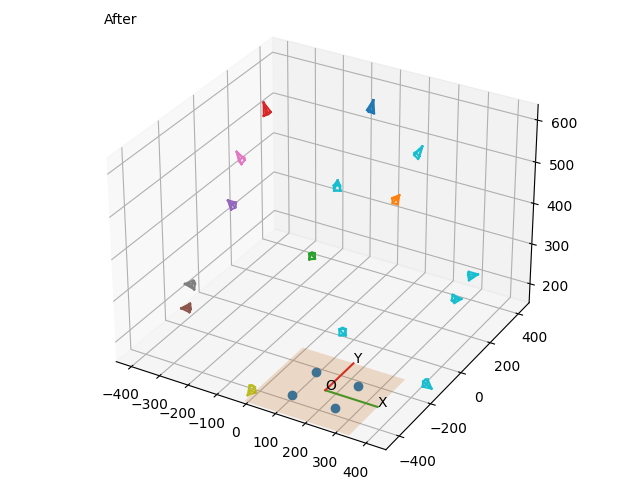

In [7]:
# Load the current calibration
camera_matrix, dist_coeffs, rmat, tvec, reproj = pycalib.util.load_calib(FILE_RESULT_TMP)

# Load the observed AR marker corners
with bz2.open(FILE_FLOOR) as fp:
    camera_params, points_3d, camera_indices, point_indices, points_2d = pycalib.bal.bal_read(fp)
Nc = len(camera_params)
print(f'{Nc} cameras, {len(points_3d)} 3D points, {len(points_2d)} observations')

# Triangulate the 3D points
P = []
for i in range(Nc):
    P.append(camera_matrix[i] @ np.hstack((rmat[i], tvec[i])))
P = np.array(P)
Y, _ = pycalib.calib.triangulateN(camera_matrix, np.zeros(dist_coeffs.shape), P, camera_indices, point_indices, points_2d)
print(f'\nThe four corners in WCS are\n{Y}\n')

# Plot
camera_params = pycalib.ba.encode_camera_params(rmat, tvec, camera_matrix, dist_coeffs)
pycalib.plot.plotCameras(camera_params, Y.T, scale=-1, title='Before', draw_zplane=True)

# Similarity transform
X = np.array( [
    [ -SCALE/2,  SCALE/2, 0 ], # TL
    [  SCALE/2,  SCALE/2, 0 ], # TR
    [  SCALE/2, -SCALE/2, 0 ], # BR
    [ -SCALE/2, -SCALE/2, 0 ], # BL
    ] ).T
R, t, s = pycalib.calib.absolute_orientation(Y, X)

# Transform the cameras
rmat2 = []
tvec2 = []
for r_w2c, t_w2c in zip (rmat, tvec):
    r_c2w = r_w2c.T
    t_c2w = - r_w2c.T @ t_w2c

    r_c2w = R @ r_c2w
    t_c2w = s * R @ t_c2w + t.reshape((3, 1))

    r_w2c = r_c2w.T
    t_w2c = - r_c2w.T @ t_c2w

    assert r_w2c.shape == (3, 3)
    assert t_w2c.shape == (3, 1)

    rmat2.append(r_w2c)
    tvec2.append(t_w2c)
rmat = np.array(rmat2)
tvec = np.array(tvec2)

# Save the result
pycalib.util.save_calib(FILE_RESULT, camera_matrix=camera_matrix, dist_coeffs=dist_coeffs, rmat=rmat, tvec=tvec, reproj=reproj)

# Triangulate again
P = []
for i in range(Nc):
    P.append(camera_matrix[i] @ np.hstack((rmat[i], tvec[i])))
P = np.array(P)
Y, _ = pycalib.calib.triangulateN(camera_matrix, np.zeros(dist_coeffs.shape), P, camera_indices, point_indices, points_2d)
print(f'\nThe four corners in WCS are\n{Y}\n')

# Plot
camera_params = pycalib.ba.encode_camera_params(rmat, tvec, camera_matrix, dist_coeffs)
_ = pycalib.plot.plotCameras(camera_params, Y.T, scale=-1, title='After', draw_zplane=True)
